# 🤪 Conditional WGAN-GP on CelebA Faces - Train

In this notebook, we'll walk through the steps required to train your own Conditional GAN on the CelebA faces dataset

In [ ]:
!git clone https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition.git

Cloning into 'Generative_Deep_Learning_2nd_Edition'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 653 (delta 35), reused 37 (delta 26), pack-reused 564
Receiving objects: 100% (653/653), 37.12 MiB | 23.80 MiB/s, done.
Resolving deltas: 100% (364/364), done.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


## 0. Parameters <a name="parameters"></a>

In [6]:
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

## 1. Prepare the data <a name="prepare"></a>

In [3]:
from google.colab import files
import pandas as pd
import io

# Step 1: Upload your CSV file
uploaded_files = files.upload()

# The keys of 'uploaded_files' dictionary are the filenames
if 'list_attr_celeba.csv' in uploaded_files:
    # Step 2: Read the CSV file into a pandas DataFrame
    attributes = pd.read_csv(io.BytesIO(uploaded_files['list_attr_celeba.csv']))
    # Step 3: Display the columns and the first few rows of the DataFrame
    print(attributes.columns)
    attributes.head()
else:
    print("File not found. Please make sure you're uploading 'list_attr_celeba.csv'.")


Saving list_attr_celeba.csv to list_attr_celeba.csv
Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


In [4]:
# Load the data
labels = attributes[LABEL].tolist()
int_labels = [x if x == 1 else 0 for x in labels]

In [5]:
from google.colab import drive
import zipfile
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Constants
IMAGE_SIZE = (64, 64)  # replace with your actual image size
BATCH_SIZE = 128  # replace with your actual batch size

# Step 1: Mount your Google Drive
drive.mount('/content/drive')

# Step 2: Define the path to your zipped dataset on Google Drive
# Replace 'path_to_your_zip_file_in_drive.zip' with the actual path to your zipped dataset in Google Drive
zip_file_path = '/content/drive/My Drive/CelebADataset/celebadataset.zip'

# Step 3: Unzip the dataset into the local Colab environment (e.g., '/content/dataset')
unzip_path = '/content/dataset'
os.makedirs(unzip_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# Step 4: Load the dataset using image_dataset_from_directory
# Ensure the directory structure in the zip file is correct and update 'img_align_celeba' if necessary
train_data = image_dataset_from_directory(
    os.path.join(unzip_path, 'img_align_celeba'),  # Update path to match the unzipped content structure
    labels='inferred',  # Assuming labels are inferred from the directory structure; update accordingly
    color_mode="rgb",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

# Check if the dataset is loaded properly
print(train_data)


Mounted at /content/drive
Found 202599 files belonging to 1 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [7]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(
    lambda x, y: (preprocess(x), tf.one_hot(y, depth=CLASSES))
)

In [8]:
# Show some faces from the training set
train_sample = sample_batch(train)

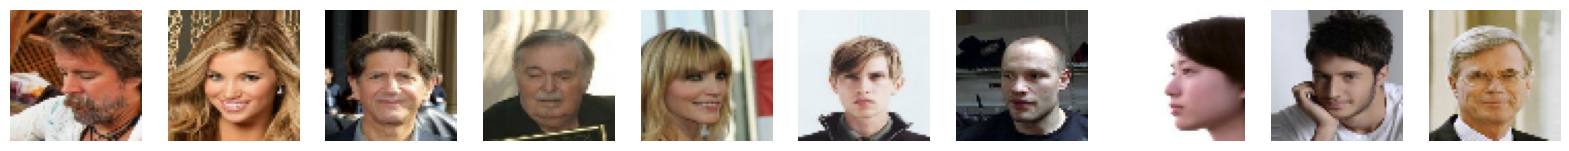

In [9]:
display(train_sample, cmap=None)

## 2. Build the GAN <a name="build"></a>

In [10]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CLASSES))
x = layers.Concatenate(axis=-1)([critic_input, label_input])
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input, label_input], critic_output)
critic.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64, 64, 2)]          0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 64, 64, 5)            0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           5184      ['concatenate[0][0]']     

In [11]:
generator_input = layers.Input(shape=(Z_DIM,))
label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input, label_input])
x = layers.Reshape((1, 1, Z_DIM + CLASSES))(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 34)                   0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 1, 1, 34)             0         ['concatenate_1[0][0]'] 

In [12]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(
        self, batch_size, real_images, fake_images, image_one_hot_labels
    ):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(
                [interpolated, image_one_hot_labels], training=True
            )

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                )

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                )
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            )
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}


In [13]:
# Create a GAN
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [14]:
if LOAD_MODEL:
    cgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [15]:
# Compile the GAN
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [16]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        # 0 label
        zero_label = np.repeat([[1, 0]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, zero_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_0.png" % (epoch),
            cmap=None,
        )

        # 1 label
        one_label = np.repeat([[0, 1]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, one_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_1.png" % (epoch),
            cmap=None,
        )

In [17]:
history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        #ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/2000


1/1 [==============================] - 8s 8s/step - c_loss: 7.4179 - c_wass_loss: -0.0526 - c_gp: 0.7471 - g_loss: -0.0191
Epoch 2/2000
1/1 [==============================] - 1s 557ms/step - c_loss: 7.1843 - c_wass_loss: -0.1821 - c_gp: 0.7366 - g_loss: 0.0943
Epoch 3/2000
1/1 [==============================] - 1s 555ms/step - c_loss: 6.9348 - c_wass_loss: -0.3238 - c_gp: 0.7259 - g_loss: 0.1943
Epoch 4/2000
1/1 [==============================] - 1s 549ms/step - c_loss: 6.5819 - c_wass_loss: -0.5093 - c_gp: 0.7091 - g_loss: 0.3379
Epoch 5/2000
1/1 [==============================] - 1s 539ms/step - c_loss: 6.1508 - c_wass_loss: -0.7629 - c_gp: 0.6914 - g_loss: 0.5499
Epoch 6/2000
1/1 [==============================] - 1s 550ms/step - c_loss: 5.4865 - c_wass_loss: -1.1869 - c_gp: 0.6673 - g_loss: 0.7884
Epoch 7/2000
1/1 [==============================] - 1s 558ms/step - c_loss: 4.8550 - c_wass_loss: -1.5434 - c_gp: 0.6398 - g_loss: 1.1475
Epoch 8/2000
1/1 [==============================]

1/1 [==============================] - 0s 123ms/step - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - c_gp: 0.0000e+00 - g_loss: 0.0000e+00


In [18]:
!pip install pillow

In [19]:
from PIL import Image

In [20]:
!mkdir output

In [21]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

## Generate images

1/1 [==============================] - 0s 467ms/step


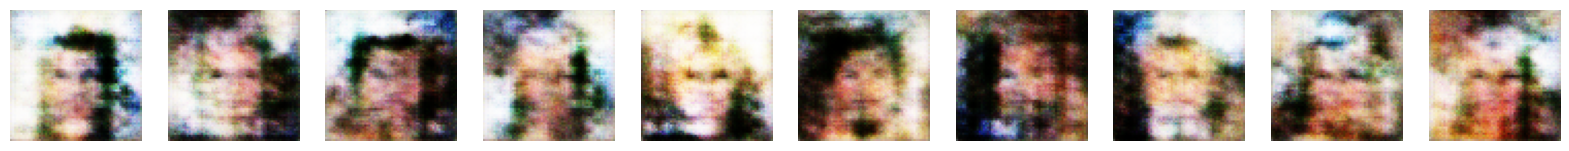

In [22]:
# 0 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[1, 0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

1/1 [==============================] - 0s 18ms/step


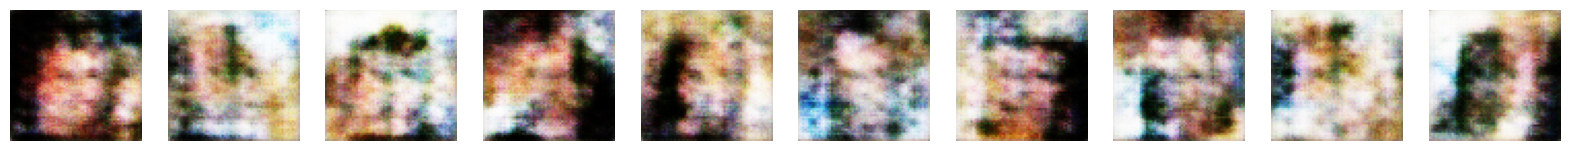

In [23]:
# 1 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[0, 1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)